# TNT motif matching 2bp deletion counts

In [12]:
import glob
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict
from pyfaidx import Fasta
from random import randint
from utils.utils import df_to_group_counts, read_rpt_files, tnt_compliance_from_row
from utils.region_sampling import random_seqs_from_bed
%matplotlib inline
sns.set_context('talk')

out_dir = "outputs/two_bp_tnt_counts"
os.makedirs(out_dir, exist_ok=True)

# Compare TNT motif compliance for all 2bp deletions vs genome

Randomly sample 100,000 deletions from the mappable genome and compare TNT
compliance with observed deletions

In [13]:
def compare_2bp_deletion_genome_tnt_counts(genome_fasta, bed_path, indel_df,
                                           cohort_name, n_samples=100_000):
    '''
    Args:
        genome_fasta (str/Fasta):
            path to genome fasta file or a pyfaidx Fasta object for genome

        bed_path (str):
            path to BED file of target regions

        indel_df (pandas.DataFrame):
            dataframe of observed indels

        cohort_name (str):
            name of cohort

        n_samples (int):
            number of random 2bp deletions to sample from genome
    
    '''
    if isinstance(genome_fasta, str):
        genome_fasta = Fasta(genome_fasta, as_raw=True,
                             sequence_always_upper=True)
    # subsample random deletion sites
    genome_sample = random_seqs_from_bed(
        bed_path,
        genome_fasta,
        lengths=[2] * n_samples)
    genome_sample['repeat_type'] = genome_sample.cosmic_repeat_type
    genome_sample['TNT_compliant'] = genome_sample.apply(
        tnt_compliance_from_row, axis=1)
    genome_sample_tnt_counts = genome_sample.groupby(
        'TNT_compliant')['TNT_compliant'].count().to_frame()
    genome_sample_tnt_counts.columns = ['Count']
    genome_sample_tnt_counts.reset_index(inplace=True)
    total = genome_sample_tnt_counts.Count.sum()
    genome_sample_tnt_counts['Percent'] = genome_sample_tnt_counts.Count.apply(
        lambda x: 100 * x/total)
    genome_sample_tnt_counts['Cohort'] = "Genome"
    two_bp_dels = indel_df[(indel_df.variant_length == 2) &
                           (indel_df.variant_type == 'Del')].copy()
    two_bp_dels['TNT_compliant'] = two_bp_dels.apply(
        tnt_compliance_from_row, axis=1)
    two_bp_del_tnt_counts = two_bp_dels.groupby(
        'TNT_compliant')['TNT_compliant'].count().to_frame()
    two_bp_del_tnt_counts.columns = ['Count']
    two_bp_del_tnt_counts.reset_index(inplace=True)
    total = two_bp_del_tnt_counts.Count.sum()
    two_bp_del_tnt_counts['Percent'] = two_bp_del_tnt_counts.Count.apply(
        lambda x: 100 * x/total)
    two_bp_del_tnt_counts['Cohort'] = cohort_name
    combined = genome_sample_tnt_counts.append(two_bp_del_tnt_counts)
    total_observed = two_bp_del_tnt_counts.Count.sum()
    combined['Scaled'] = combined.Percent/100 * total_observed
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.barplot(data=combined,
                ax=ax,
                hue='TNT_compliant',
                hue_order=[True, False],
                x='Cohort',
                y='Percent')
    sns.despine()
    ax.set_ylim(0, 100)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, ['TNT', 'Other'], frameon=False)
    return combined

## RNase H2 Null Mouse Tumours


In [14]:
mouse_fasta_path = "ref/GRCm38/GRCm38_68.fa"
grcm38_fa = Fasta(mouse_fasta_path, as_raw=True, sequence_always_upper=True)
mouse_indels = pd.read_csv(
    "data/mouse_rnaseh2null_tumours/mouse_tumour_indels.csv")

Fisher's Exact: 1.69e-28


TNT_compliant  Count    Percent                 Cohort     Scaled
0          False  60273  60.273000                 Genome  137.42244
1           True  39727  39.727000                 Genome   90.57756
0          False     27  11.842105  RNase H2 Null Tumours   27.00000
1           True    201  88.157895  RNase H2 Null Tumours  201.00000

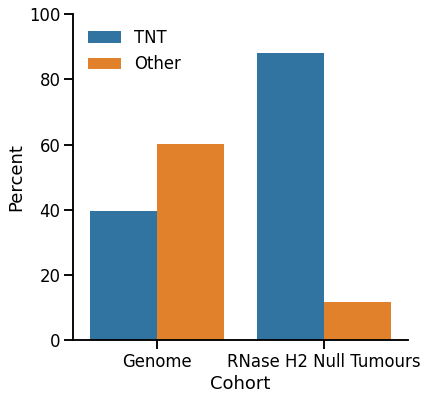

In [15]:
grcm38_umap = "data/mouse_rnaseh2null_tumours/genome_data/GRCm38_k100.umap.no_MT.bed.gz"
mouse_all_del_2bp_tnt_counts = compare_2bp_deletion_genome_tnt_counts(
    grcm38_fa,
    grcm38_umap,
    mouse_indels,
    "RNase H2 Null Tumours")
mouse_all_del_2bp_tnt_counts.to_csv(
    os.path.join(out_dir, "mouse_all_del_2bp_tnt_counts.csv"),
    index=False)
mouse_all_del_2bp_tnt_counts

## RPE1 Mutation Accumulation Experiment

RNASEH2A KO (AKO1_4) and RNASEH2B KO (BKO1_4) vs WT RPE1 cells after long term bottleneck culture.

In [16]:
rpe1_indel_df = pd.read_csv("data/rpe1_bottleneck/rpe1_indels.csv")
rpe1_ko_df = rpe1_indel_df[rpe1_indel_df.Status == 'KO']
hg38_fasta_path = "ref/hg38/hg38.fa"
hg38_fa = Fasta(hg38_fasta_path, as_raw=True, sequence_always_upper=True)

Fisher's Exact: 3.85461e-12


TNT_compliant  Count    Percent                    Cohort    Scaled
0          False  61269  61.269000                    Genome  60.04362
1           True  38731  38.731000                    Genome  37.95638
0          False     14  14.285714  RNase H2 Null RPE1 cells  14.00000
1           True     84  85.714286  RNase H2 Null RPE1 cells  84.00000

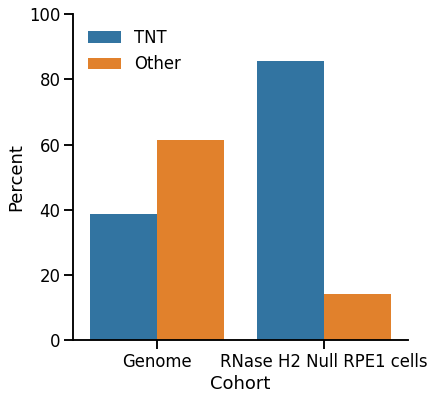

In [17]:
hg38_umap = "data/rpe1_bottleneck/genome_data/hg38_k100.umap.bed.gz"
rpe1_all_del_2bp_tnt_counts = compare_2bp_deletion_genome_tnt_counts(
    hg38_fa,
    hg38_umap,
    rpe1_ko_df,
    "RNase H2 Null RPE1 cells")
rpe1_all_del_2bp_tnt_counts.to_csv(
    os.path.join(out_dir, "rpe1_all_del_2bp_tnt_counts.csv"),
    index=False)
rpe1_all_del_2bp_tnt_counts

## Gene4Denovo



In [18]:
g4d_indel_df = pd.read_csv("data/gene4denovo/gene4denovo_indels.csv",
                           dtype={'chrom': str, 'pos': int})
        
hg19_fasta_path = "ref/hg19/hg19.fa"
hg19_fa = Fasta(hg19_fasta_path, as_raw=True, sequence_always_upper=True)

Fisher's Exact: 0


TNT_compliant  Count   Percent       Cohort      Scaled
0          False  61136  61.13600       Genome  3404.66384
1           True  38864  38.86400       Genome  2164.33616
0          False   1369  24.58251  Gene4Denovo  1369.00000
1           True   4200  75.41749  Gene4Denovo  4200.00000

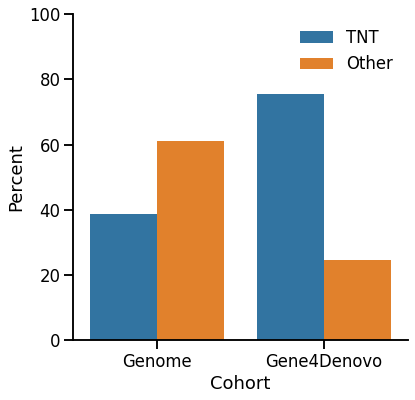

In [19]:
hg19_umap = "data/gene4denovo/genome_data/hg19_k100.umap.bed.gz"
g4d_all_del_2bp_tnt_counts = compare_2bp_deletion_genome_tnt_counts(
    hg19_fa,
    hg19_umap,
    g4d_indel_df,
    "Gene4Denovo")
g4d_all_del_2bp_tnt_counts.to_csv(
    os.path.join(out_dir, "gene4denovo_all_del_2bp_tnt_counts.csv"),
    index=False)
g4d_all_del_2bp_tnt_counts


In [26]:
g4d_all_del_2bp_tnt_counts

TNT_compliant  Count   Percent       Cohort      Scaled
0          False  61136  61.13600       Genome  3404.66384
1           True  38864  38.86400       Genome  2164.33616
0          False   1369  24.58251  Gene4Denovo  1369.00000
1           True   4200  75.41749  Gene4Denovo  4200.00000

## rnh201Δ pol2-M644G yeast

In [20]:
yeast_indel_df = pd.read_csv(
    "data/pol2_m644g_rnh201_delta_yeast/pol2_M644G_rnh201_dnms.indels.csv")
gse_fasta_path = "ref/GSE56939_L03_ref_v2/GSE56939_L03_ref_v2.fa"
gse_fa = Fasta(gse_fasta_path, as_raw=True, sequence_always_upper=True)

In [21]:
gse_bed = "ref/GSE56939_L03_ref_v2/GSE56939_L03_ref_v2.bed"
with open(gse_bed, 'wt') as bed_fh:
    for chrom, seq in gse_fa.items():
        bed_fh.write("{}\t{}\t{}\n".format(chrom, 0, seq.unpadded_len))

Fisher's Exact: 1.06257e-20


TNT_compliant  Count    Percent                    Cohort    Scaled
0          False  62354  62.354000                    Genome  58.61276
1           True  37646  37.646000                    Genome  35.38724
0          False      3   3.191489  rnh201Δ pol2-M644G yeast   3.00000
1           True     91  96.808511  rnh201Δ pol2-M644G yeast  91.00000

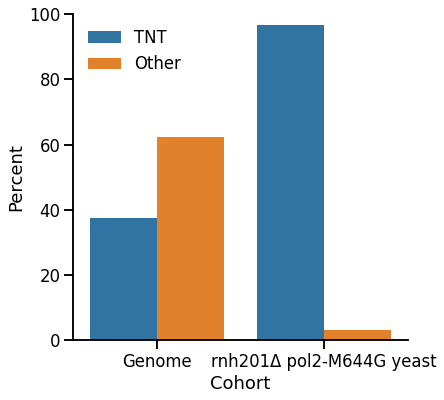

In [27]:
yeast_all_del_2bp_tnt_counts = compare_2bp_deletion_genome_tnt_counts(
    gse_fa,
    gse_bed,
    yeast_indel_df,
    "rnh201Δ pol2-M644G yeast")
yeast_all_del_2bp_tnt_counts.to_csv(
    os.path.join(out_dir, "pol2_M644G_rnh201_all_del_2bp_tnt_counts.csv"),
    index=False)
yeast_all_del_2bp_tnt_counts

# Compare TNT motif compliance for 2bp deletions at repeats

For perfect repeats (STRs) and imperfect repeatst (SNMH), randomly sample
100,000 two bp deletions from the mappable genome and compare TNT compliance
with observed deletions at perfect/imperfect repeats

In [23]:
def random_sample_genome_repeats(df, n, return_counts=True):
    total = df.total_bp.sum() - 1
    cidx = df.total_bp.cumsum()
    g_smpl = defaultdict(list)
    for i in range(n):
        r_int = randint(0, total)
        j = cidx.searchsorted(r_int, side='right')
        r_type = df.repeat_type.values[j]
        r_rpt = df.repeat_unit.values[j]
        rpt_len = df.repeat_length.values[j]
        if r_type == 'Imperfect':
            r_len = rpt_len - len(r_rpt)
            rpt_seq = r_rpt[:r_len]
        else:
            rpt_seq = r_rpt
        tnt_compliant = 'A' in rpt_seq or 'T' in rpt_seq
        g_smpl['TNT_compliant'].append(tnt_compliant)
        g_smpl['variant_length'].append(df.variant_length.values[j])
        g_smpl['repeat_unit'].append(rpt_seq)
        g_smpl['repeat_type'].append(r_type)
    g_smpl = pd.DataFrame.from_dict(g_smpl)
    if return_counts:
        count_cols = ['TNT_compliant', 'variant_length', 'repeat_type']
        g_counts = g_smpl.groupby(count_cols)['variant_length'].sum().to_frame()
        g_counts.columns = ['bp']
        return g_counts.reset_index()
    return g_smpl


def compare_2bp_repeats_tnt_counts(rpt_files, indel_df, cohort_name,
                                   n_samples=100_000):
    '''
    Args:
        rpt_files: 
            paths to files containing repeat count files. See the description
            under "Identification of genomewide STR and MH sequences" in the
            notebook "04_deleted_dinucleotide_sequence_analysis.ipynb" for an
            explanation of how to generate the repeat count files.


        indel_df:
            dataframe containing observed indels.
        
        cohort_name:
            name of the cohort.

        n_samples:
            number of random samples to draw from the repeat count files.
    
    '''
    rpt_df = read_rpt_files(rpt_files)
    two_bp_rpts = rpt_df[rpt_df.variant_length == 2]
    perf_smpl = random_sample_genome_repeats(
        two_bp_rpts[two_bp_rpts.repeat_type == 'Perfect'],
        n_samples,
        return_counts=True)
    perf_smpl['Percent'] = perf_smpl.bp.apply(
        lambda x: 100 * x/perf_smpl.bp.sum())
    impf_smpl = random_sample_genome_repeats(
        two_bp_rpts[two_bp_rpts.repeat_type == 'Imperfect'],
        n_samples,
        return_counts=True)
    impf_smpl['Percent'] = impf_smpl.bp.apply(
        lambda x: 100 * x/impf_smpl.bp.sum())
    rpt_smpl = perf_smpl.append(impf_smpl)
    rpt_smpl.drop('variant_length', axis=1, inplace=True)
    rpt_dels = indel_df[(indel_df.variant_length == 2) &
                        (indel_df.variant_type == 'Del')].copy()
    rpt_dels['TNT_compliant'] = rpt_dels.apply(
        tnt_compliance_from_row, axis=1)
    del_tnt_counts = df_to_group_counts(rpt_dels,
                                        ['TNT_compliant', 'repeat_type'])
    di = del_tnt_counts[del_tnt_counts.repeat_type == 'No repeat'].index
    del_tnt_counts.drop(di, inplace=True)
    totals = dict()
    for rpt_type in del_tnt_counts.repeat_type.unique():
        totals[rpt_type] = del_tnt_counts[del_tnt_counts.repeat_type == rpt_type].Count.sum()
    del_tnt_counts['Percent'] = del_tnt_counts.apply(
        lambda x: 100 * x.Count / totals[x.repeat_type], axis=1)
    del_tnt_counts['Cohort'] = cohort_name
    rpt_smpl['Count'] = rpt_smpl.bp
    rpt_smpl['Cohort'] = 'Genome'
    combined = rpt_smpl.append(del_tnt_counts)
    combined['Scaled'] = combined.apply(
        lambda x: x.Percent/100 * totals[x.repeat_type], axis=1)
    sns.catplot(data=combined,
                kind='bar',
                col='repeat_type',
                hue='TNT_compliant',
                aspect=1.5,
                height=6,
                hue_order=[True, False],
                x='Cohort',
                y='Percent')
    return combined

## RNase H2 Null Mouse Tumours


Perfect repeats: Fisher's Exact: 0.000369338
Imperfect repeats: Fisher's Exact: 5.79591e-09


TNT_compliant repeat_type        bp  Percent     Count  \
0          False     Perfect   17754.0    8.877   17754.0   
1           True     Perfect  182246.0   91.123  182246.0   
0          False   Imperfect   62892.0   31.446   62892.0   
1           True   Imperfect  137108.0   68.554  137108.0   
0          False   Imperfect       NaN    0.000       0.0   
2          False     Perfect       NaN    0.000       0.0   
3           True   Imperfect       NaN  100.000      77.0   
5           True     Perfect       NaN  100.000     124.0   

                  Cohort     Scaled  
0                 Genome   11.00748  
1                 Genome  112.99252  
0                 Genome   24.21342  
1                 Genome   52.78658  
0  RNase H2 Null Tumours    0.00000  
2  RNase H2 Null Tumours    0.00000  
3  RNase H2 Null Tumours   77.00000  
5  RNase H2 Null Tumours  124.00000

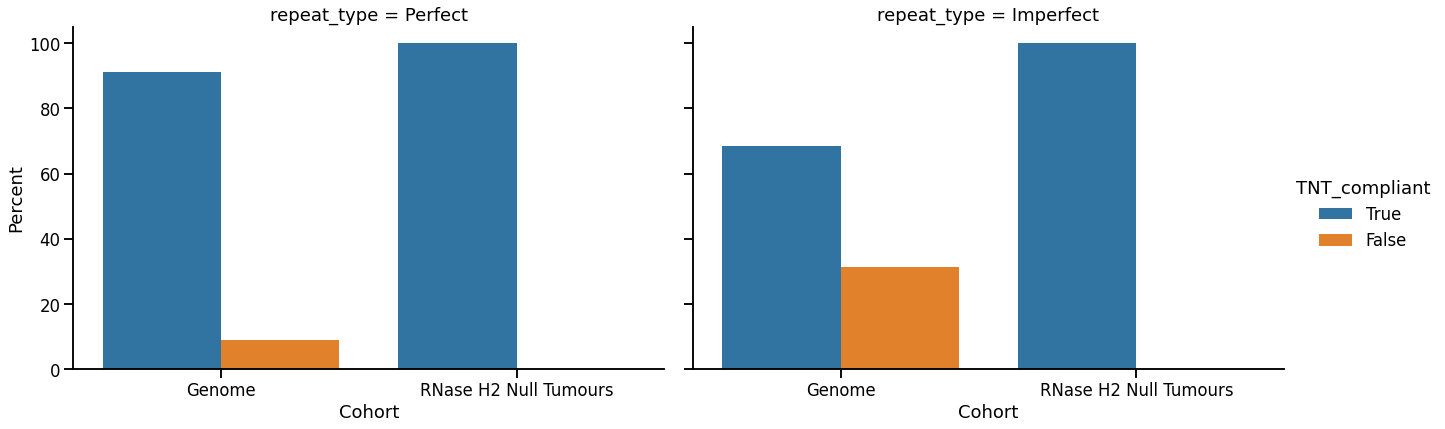

In [24]:
mouse_rpt_del_2bp_tnt_counts = compare_2bp_repeats_tnt_counts(
    glob.glob("data/genome_scans/rpt_counts/grcm38_rpts_*counts.txt"),
    mouse_indels,
    'RNase H2 Null Tumours')
mouse_rpt_del_2bp_tnt_counts.to_csv(
    os.path.join(out_dir, "mouse_rpt_dels_2bp_tnt_counts.csv"),
    index=False)
mouse_rpt_del_2bp_tnt_counts

## RPE1 Mutation Accumulation Experiment

RNASEH2A KO (AKO1_4) and RNASEH2B KO (BKO1_4) vs WT RPE1 cells after long term bottleneck culture.

Perfect repeats: Fisher's Exact: 0.0567423
Imperfect repeats: Fisher's Exact: 0.000797013


TNT_compliant repeat_type        bp  Percent     Count  \
0          False     Perfect   17104.0    8.552   17104.0   
1           True     Perfect  182896.0   91.448  182896.0   
0          False   Imperfect   66354.0   33.177   66354.0   
1           True   Imperfect  133646.0   66.823  133646.0   
0          False   Imperfect       NaN    0.000       0.0   
2          False     Perfect       NaN    0.000       0.0   
3           True   Imperfect       NaN  100.000      30.0   
5           True     Perfect       NaN  100.000      54.0   

                     Cohort    Scaled  
0                    Genome   4.61808  
1                    Genome  49.38192  
0                    Genome   9.95310  
1                    Genome  20.04690  
0  RNase H2 Null RPE1 cells   0.00000  
2  RNase H2 Null RPE1 cells   0.00000  
3  RNase H2 Null RPE1 cells  30.00000  
5  RNase H2 Null RPE1 cells  54.00000

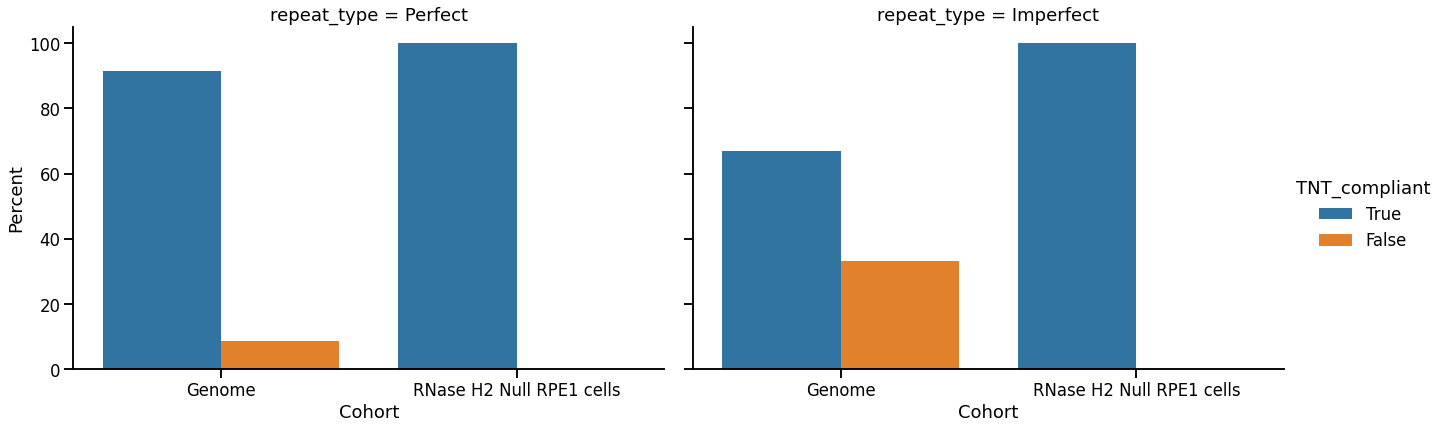

In [11]:
rpe1_rpt_del_2bp_tnt_counts = compare_2bp_repeats_tnt_counts(
    glob.glob("data/genome_scans/rpt_counts/hg38_rpts_*counts.txt"),
    rpe1_ko_df,
    'RNase H2 Null RPE1 cells')
rpe1_rpt_del_2bp_tnt_counts.to_csv(
    os.path.join(out_dir, "rpe1_rpt_dels_2bp_tnt_counts.csv"),
    index=False)
rpe1_rpt_del_2bp_tnt_counts

## Gene4Denovo



Perfect repeats: Fisher's Exact: 1.34067e-42
Imperfect repeats: Fisher's Exact: 1.81317e-30


TNT_compliant repeat_type        bp    Percent     Count       Cohort  \
0          False     Perfect   16934.0   8.467000   16934.0       Genome   
1           True     Perfect  183066.0  91.533000  183066.0       Genome   
0          False   Imperfect   66080.0  33.040000   66080.0       Genome   
1           True   Imperfect  133920.0  66.960000  133920.0       Genome   
0          False   Imperfect       NaN  12.717292     139.0  Gene4Denovo   
2          False     Perfect       NaN   1.457195      48.0  Gene4Denovo   
3           True   Imperfect       NaN  87.282708     954.0  Gene4Denovo   
5           True     Perfect       NaN  98.542805    3246.0  Gene4Denovo   

       Scaled  
0   278.90298  
1  3015.09702  
0   361.12720  
1   731.87280  
0   139.00000  
2    48.00000  
3   954.00000  
5  3246.00000

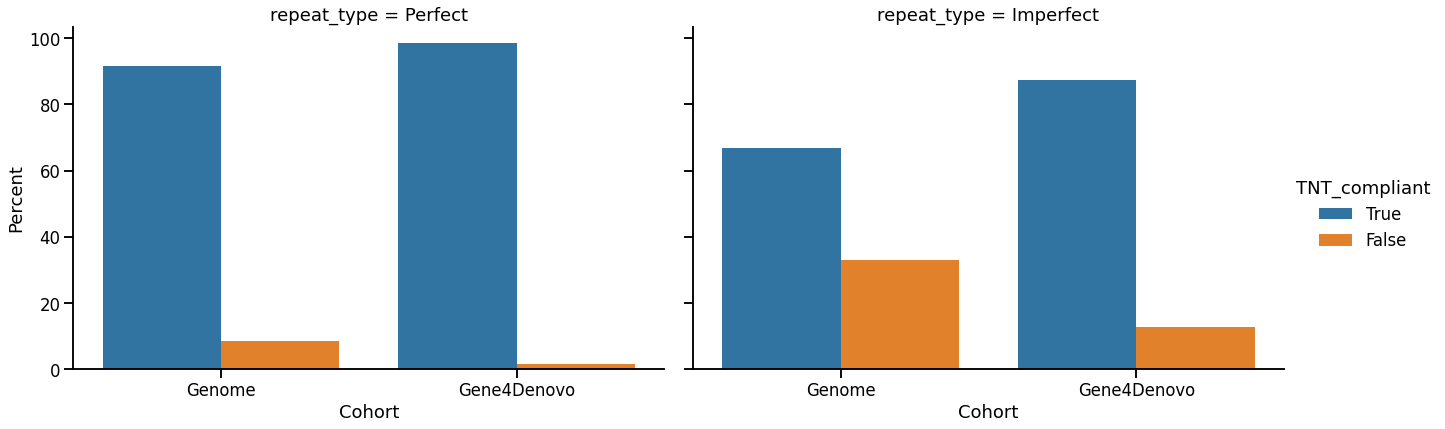

In [12]:
g4d_rpt_del_2bp_tnt_counts = compare_2bp_repeats_tnt_counts(
    glob.glob("data/genome_scans/rpt_counts/grch37_rpts_*counts.txt"),
    g4d_indel_df,
    'Gene4Denovo')
g4d_rpt_del_2bp_tnt_counts.to_csv(
    os.path.join(out_dir, "gene4denovo_rpt_dels_2bp_tnt_counts.csv"),
    index=False)
g4d_rpt_del_2bp_tnt_counts

## rnh201Δ pol2-M644G yeast

Perfect repeats: Fisher's Exact: 0.0286178
Imperfect repeats: Fisher's Exact: 1


TNT_compliant repeat_type        bp  Percent     Count  \
0          False     Perfect   12962.0    6.481   12962.0   
1           True     Perfect  187038.0   93.519  187038.0   
0          False   Imperfect   53812.0   26.906   53812.0   
1           True   Imperfect  146188.0   73.094  146188.0   
0          False   Imperfect       NaN    0.000       0.0   
2          False     Perfect       NaN    0.000       0.0   
3           True   Imperfect       NaN  100.000       3.0   
5           True     Perfect       NaN  100.000      88.0   

                    Cohort    Scaled  
0                   Genome   5.70328  
1                   Genome  82.29672  
0                   Genome   0.80718  
1                   Genome   2.19282  
0  nh201Δ pol2-M644G yeast   0.00000  
2  nh201Δ pol2-M644G yeast   0.00000  
3  nh201Δ pol2-M644G yeast   3.00000  
5  nh201Δ pol2-M644G yeast  88.00000

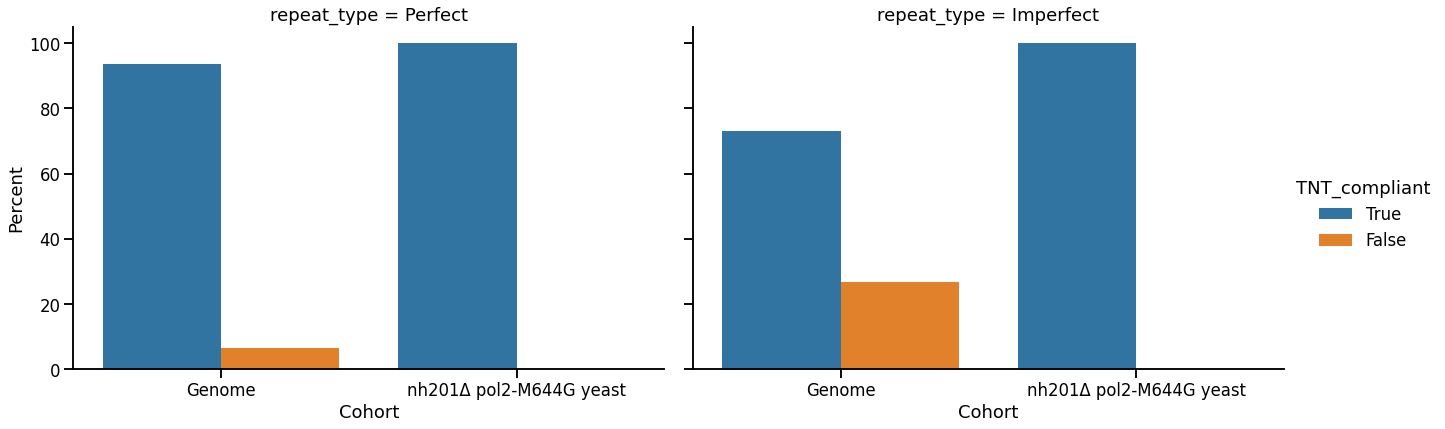

In [25]:
yeast_rpt_del_2bp_tnt_counts = compare_2bp_repeats_tnt_counts(
    glob.glob("data/genome_scans/rpt_counts/GSE56939_L03_ref_v2_*counts.txt"),
    yeast_indel_df,
    'nh201Δ pol2-M644G yeast')
yeast_rpt_del_2bp_tnt_counts.to_csv(
    os.path.join(out_dir, "pol2_M644G_rnh201_rpt_dels_2bp_tnt_counts.csv"),
    index=False)
yeast_rpt_del_2bp_tnt_counts